# Previous code

## NOTE

#### IF INTENTION IS TO DOWNLOAD PACKAGES WHICH ARE NOT INSTALLED ON CONDA BY DEFAULT:

1. Use "conda install mypackage".

2. Only if it fails then try "conda install --channel=conda-forge mypackage".

3. Even if this fails, then try to find a conda channel that has your package of interest.

4. If and only if this fails, then resort to "pip install mypackage" with caution.

5. Although, it is very unlikely, but if and only if this fails, then use "brew install mypackage".

In [ ]:
# python -m pip install packagename, handles some of conflicts related to a simple "pip install packagename"
!python -m pip install mediapipe 

In [ ]:
!pip install opencv-python

In [1]:
# lists available cameras, use indexes for cv2 to VideoCapture
!ffmpeg -f avfoundation -list_devices true -i ""

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/anaconda3/envs/pytorch_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 

In [43]:
import mediapipe as mp
import cv2
import time
import numpy as np

cap = cv2.VideoCapture(1)
#cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640) # or alternatively can set as 3
#cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # or alternatively can set as 4
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30) # frames per second

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4)

pose_without_hand_face_leg_torso = frozenset([(11, 12),(11, 13),(12, 14),(13, 15),(14, 16)])
pose_landmarks_to_remove = [0,1,2,3,4,5,6,7,8,9,10,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]

pose_data = []
left_hand_data = []
right_hand_data = []
face_data = []

start_time = time.time()
prev_time = time.time()
while cap.isOpened():
    success, frame = cap.read()
    # Calculating the FPS
    current_time = time.time()
    fps = 1/(current_time - prev_time) if (current_time - prev_time) > 0 else 0
    prev_time = current_time
    
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results_landmarks = holistic.process(frame)

    # Extract landmarks as numpy arrays for each frame, if not detected than fill with zeros
    if results_landmarks.pose_landmarks:
        for i in pose_landmarks_to_remove:
            results_landmarks.pose_landmarks.landmark[i].visibility = 0.0
            
        pose_ndarray = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results_landmarks.pose_landmarks.landmark])
    else:
        pose_ndarray = np.zeros((33,4))

    # left hand ndarray
    
    if results_landmarks.left_hand_landmarks:
        left_hand_ndarray = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.left_hand_landmarks.landmark])
    else:
        left_hand_ndarray = np.zeros((21,3))
        
    # right hand ndarray

    if results_landmarks.right_hand_landmarks:
        right_hand_ndarray = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.right_hand_landmarks.landmark])
    else:
        right_hand_ndarray = np.zeros((21, 3))

    # face ndarray
    if results_landmarks.face_landmarks:
        face_ndarray = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.face_landmarks.landmark])
    else:
        face_ndarray = np.zeros((468, 3))

    # Append ndarrays of each frame into the list
    pose_data.append(pose_ndarray)
    left_hand_data.append(left_hand_ndarray)
    right_hand_data.append(right_hand_ndarray)
    face_data.append(face_ndarray)
    
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    
    mp_drawing.draw_landmarks(
        image = frame,
        landmark_list = results_landmarks.face_landmarks,
        connections = mp_holistic.FACEMESH_TESSELATION,
        landmark_drawing_spec = mp_drawing.DrawingSpec(color=(0,244,0), thickness=2, circle_radius=2),
        connection_drawing_spec = mp_drawing.DrawingSpec(color=(0,255,255), thickness=1, circle_radius=2)
    )

    mp_drawing.draw_landmarks(
        image = frame,
        landmark_list = results_landmarks.right_hand_landmarks,
        connections = mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255,0,0), thickness=8, circle_radius=2),
        connection_drawing_spec = mp_drawing.DrawingSpec(color=(220,0,0), thickness=8, circle_radius=2)
    )

    mp_drawing.draw_landmarks(
        image = frame,
        landmark_list = results_landmarks.left_hand_landmarks,
        connections = mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec = mp_drawing.DrawingSpec(color=(0,0,220), thickness=8, circle_radius=2),
        connection_drawing_spec = mp_drawing.DrawingSpec(color=(0,0,255), thickness=8, circle_radius=2)
    )

    mp_drawing.draw_landmarks(
        image = frame,
        landmark_list = results_landmarks.pose_landmarks,
        connections = pose_without_hand_face_leg_torso, # instead of mp_holistic.POSE_CONNECTIONS
        landmark_drawing_spec = mp_drawing.DrawingSpec(color=(0,255,0), thickness=17, circle_radius=6),
        connection_drawing_spec = mp_drawing.DrawingSpec(color=(0,255,0), thickness=17, circle_radius=2)
    )

    frame = cv2.flip(frame, 1)
    
    cv2.putText(
        frame,
        f"FPS: {fps:.2f}",
        (10,30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0,255,0),
        2,
        cv2.LINE_AA
    )

    if not success:
        print("Frames are not found!")
        break
    
    cv2.imshow("Landmarks test", frame)
    
    if cv2.waitKey(10)&0xFF==ord('q'):
        end_time = time.time() - start_time
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
print(f"{end_time} seconds the webcam was used.")

pose_data = np.array(pose_data)       
left_hand_data = np.array(left_hand_data) 
right_hand_data = np.array(right_hand_data)
face_data = np.array(face_data)

print("Pose data shape:", pose_data.shape)
print("Left hand data shape:", left_hand_data.shape)
print("Right hand data shape:", right_hand_data.shape)
print("Face data shape:", face_data.shape)

I0000 00:00:1761976231.578381 17336143 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1761976231.664445 17365615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761976231.680030 17365615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761976231.683366 17365615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761976231.683412 17365617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761976231.684153 17365613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling su

51.62247395515442 seconds the webcam was used.
Pose data shape: (765, 33, 4)
Left hand data shape: (765, 21, 3)
Right hand data shape: (765, 21, 3)
Face data shape: (765, 468, 3)


In [26]:
import mediapipe as mp
import cv2
import time 
import numpy as np


cap = cv2.VideoCapture(1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.4,
                               min_tracking_confidence=0.4)


pose_without_hand_face_leg_torso = frozenset([(11,12),(11,13),(12,14),
                                             (13,15),(14,16)])

pose_landmarks_to_remove = [0,1,2,3,4,5,6,7,8,9,10,
                            17,18,19,20,21,22,23,24,25,26,
                            27,28,29,30,31,32]

pose_data, left_hand_data, right_hand_data, face_data = [], [], [], []

start_time = time.time()
prev_time = time.time()

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Frames are not found!")
        break

    current_time = time.time()
    fps = 1/(current_time - prev_time) if (current_time - prev_time) > 0 else 0
    prev_time = current_time

    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_landmarks = holistic.process(frame)


    # Pose
    if results_landmarks.pose_landmarks:
        for i in pose_landmarks_to_remove:
            results_landmarks.pose_landmarks.landmark[i].visibility = 0.0
        pose_ndarray = np.array([[lm.x, lm.y, lm.z, lm.visibility]
                                 for lm in results_landmarks.pose_landmarks.landmark])
    else:
        pose_ndarray = np.zeros((33,4))

    # Left hand
    if results_landmarks.left_hand_landmarks:
        left_hand_ndarray = np.array([[lm.x, lm.y, lm.z]
                                      for lm in results_landmarks.left_hand_landmarks.landmark])
    else:
        left_hand_ndarray = np.zeros((21,3))

    # Right hand
    if results_landmarks.right_hand_landmarks:
        right_hand_ndarray = np.array([[lm.x, lm.y, lm.z]
                                       for lm in results_landmarks.right_hand_landmarks.landmark])
    else:
        right_hand_ndarray = np.zeros((21,3))

    # Face
    if results_landmarks.face_landmarks:
        face_ndarray = np.array([[lm.x, lm.y, lm.z]
                                 for lm in results_landmarks.face_landmarks.landmark])
    else:
        face_ndarray = np.zeros((468,3))

    # Append to lists
    pose_data.append(pose_ndarray)
    left_hand_data.append(left_hand_ndarray)
    right_hand_data.append(right_hand_ndarray)
    face_data.append(face_ndarray)

    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # --------------------------------------------------------------
    # *** NEW: DRAW ONLY LANDMARKS ON A BLACK BACKGROUND ***
    # --------------------------------------------------------------
    h, w = frame.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)   # <-- black image

    # ---- Face mesh (tesselation) ---------------------------------
    if results_landmarks.face_landmarks:
        mp_drawing.draw_landmarks(
            image=canvas,
            landmark_list=results_landmarks.face_landmarks,
            connections=mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,244,0),
                                                        thickness=1,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,255),
                                                          thickness=1)
        )
    

    # ---- Right hand ---------------------------------------------
    if results_landmarks.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=canvas,
            landmark_list=results_landmarks.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0),
                                                        thickness=8,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(220,0,0),
                                                          thickness=8)
        )

    # ---- Left hand ----------------------------------------------
    if results_landmarks.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=canvas,
            landmark_list=results_landmarks.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,220),
                                                        thickness=8,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255),
                                                          thickness=8)
        )

    # ---- Pose (only the connections you kept) -------------------
    if results_landmarks.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=canvas,
            landmark_list=results_landmarks.pose_landmarks,
            connections=pose_without_hand_face_leg_torso,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0),
                                                        thickness=17,
                                                        circle_radius=4),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0),
                                                          thickness=17)
        )


    canvas = cv2.flip(canvas, 1)

    #cv2.putText(
    #    canvas,
    #    f"FPS: {fps:.2f}",
    #    (10, 30),
    #    cv2.FONT_HERSHEY_SIMPLEX,
    #    1.0,
    #    (0, 255, 0),
    #    2,
    #    cv2.LINE_AA
    #)

    cv2.imshow("Landmarks test", canvas)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        end_time = time.time() - start_time
        break


cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print(f"{end_time:.2f} seconds the webcam was used.")

# Convert lists → numpy arrays
pose_data      = np.array(pose_data)
left_hand_data = np.array(left_hand_data)
right_hand_data= np.array(right_hand_data)
face_data      = np.array(face_data)

print("Pose data shape:", pose_data.shape)
print("Left hand data shape:", left_hand_data.shape)
print("Right hand data shape:", right_hand_data.shape)
print("Face data shape:", face_data.shape)

I0000 00:00:1761981689.916879 17421995 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1761981689.996846 17437202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761981690.015283 17437202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761981690.020806 17437202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761981690.021191 17437206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761981690.021224 17437207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling su

9.25 seconds the webcam was used.
Pose data shape: (127, 33, 4)
Left hand data shape: (127, 21, 3)
Right hand data shape: (127, 21, 3)
Face data shape: (127, 468, 3)


# 1. Install and Import Dependencies

In [1]:
!python --version

Python 3.9.23


In [5]:
!pip install opencv-python

  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.0.2 which is incompatible.


In [6]:
# python -m pip install packagename, handles some of conflicts related to a simple "pip install packagename"
!python -m pip install mediapipe 

  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [7]:
!conda install scikit-learn

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [1]:
import cv2
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import time
import numpy as np

In [89]:
# lists available cameras, use indexes for cv2 to VideoCapture
!ffmpeg -f avfoundation -list_devices true -i ""

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/anaconda3/envs/pytorch_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 

# 2. Detect and Draw Landmarks using Mediapipe Holistic

In [124]:
# lists available cameras, use indexes for cv2 to VideoCapture
!ffmpeg -f avfoundation -list_devices true -i ""

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/anaconda3/envs/pytorch_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 

In [2]:
# Creating instances of the required objects
mp_holistic = mp.solutions.holistic
mp_drawing_utils = mp.solutions.drawing_utils
holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.6, 
                                          min_tracking_confidence=0.6,
                                          static_image_mode=False)


# These landmarks are of no importance for this project, that is why we will remove them by setting their visibility to 0.0
pose_without_hand_face_leg_torso = frozenset([(11, 12),(11, 13),(12, 14),(13, 15),(14, 16)])
pose_landmarks_to_remove = [0,1,2,3,4,5,6,7,8,9,10,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]


# This function, detects the landmarks, but does not render them in the video
def mediapipe_landmarks_detection(frame, model, black_bg=False):
    # Since MediaPipe accepts only RGB format, and OpenCV captures in BGR format
    # we must convert to compatible formats and convert it back 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # .flags.writeable is used for avoiding creating duplicate copies of frames during format conversion
    # hence increasing the performance
    frame.flags.writeable = False
    results_landmarks = model.process(frame)

    # We do not need pose landmarks for hand, torso, legs
    if results_landmarks.pose_landmarks:
        for i in pose_landmarks_to_remove:
            results_landmarks.pose_landmarks.landmark[i].visibility = 0.0
    
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # For privacy concerns, everything will be black but the landmarks
    if black_bg:
        h, w = frame.shape[:2]
        frame = np.zeros((h, w , 3), dtype=np.uint8)
    
    return frame, results_landmarks


# Based on detected landmarks, this function renders landmarks and their connections into the Video
def draw_landmarks_on_video(frame, results_landmarks):

    # ---- Face mesh (tesselation) ---------------------------------
    if results_landmarks.face_landmarks:
        mp_drawing_utils.draw_landmarks(
            image=frame,
            landmark_list=results_landmarks.face_landmarks,
            connections=mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,244,0),
                                                        thickness=1,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,255,255),
                                                          thickness=1)
        )
    
    # ---- Right hand ---------------------------------------------
    if results_landmarks.right_hand_landmarks:
        mp_drawing_utils.draw_landmarks(
            image=frame,
            landmark_list=results_landmarks.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_utils.DrawingSpec(color=(255,0,0),
                                                        thickness=8,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing_utils.DrawingSpec(color=(220,0,0),
                                                          thickness=8)
        )
        
    # ---- Left hand ----------------------------------------------
    if results_landmarks.left_hand_landmarks:
        mp_drawing_utils.draw_landmarks(
            image=frame,
            landmark_list=results_landmarks.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,0,220),
                                                        thickness=8,
                                                        circle_radius=2),
            connection_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,0,255),
                                                          thickness=8)
        )

    # ---- Pose (only the connections we kept) -------------------
    if results_landmarks.pose_landmarks:
        mp_drawing_utils.draw_landmarks(
            image=frame,
            landmark_list=results_landmarks.pose_landmarks,
            connections=pose_without_hand_face_leg_torso,
            landmark_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,255,0),
                                                        thickness=17,
                                                        circle_radius=4),
            connection_drawing_spec=mp_drawing_utils.DrawingSpec(color=(0,255,0),
                                                          thickness=17)
        )
    

I0000 00:00:1762056685.650987 17908009 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1762056685.745960 17908226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762056685.761239 17908222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762056685.765112 17908224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762056685.765112 17908223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762056685.765713 17908225 inference_feedback_manager.cc:114] Feedback manager requires

In [91]:
# lists available cameras, use indexes for cv2 to VideoCapture
!ffmpeg -f avfoundation -list_devices true -i ""

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/anaconda3/envs/pytorch_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 

In [98]:
import cv2

# Quick check which camera is working
for i in range(5):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"camera {i} is working.")
    else:
        print(f"camera {i} is not working.")

camera 0 is working.
camera 1 is working.
camera 2 is working.
camera 3 is not working.
camera 4 is not working.


OpenCV: out device of bound (0-2): 3
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-2): 4
OpenCV: camera failed to properly initialize!


In [128]:
#Optional, testing whether drawing landmarks works

VIDEO_DEVICE = 1
cap = cv2.VideoCapture(VIDEO_DEVICE)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.6, 
                                          min_tracking_confidence=0.6,
                                          static_image_mode=False)

start_time = time.time()
prev_time = time.time()
while cap.isOpened():
    success, frame = cap.read()
        
    if not success:
        print("Frames are not found!")
        break

    # detect landmarks
    frame, results_landmarks = mediapipe_landmarks_detection(frame, holistic, black_bg=False)

    # render landmarks on video camera
    draw_landmarks_on_video(frame=frame, results_landmarks=results_landmarks)

    # Calculating the FPS
    current_time = time.time()
    fps = 1/(current_time - prev_time) if (current_time - prev_time) > 0 else 0
    prev_time = current_time

    # flip the camera so it feels more natural
    frame = cv2.flip(frame, 1)

    # Display FPS on screen OPTIONAL
    cv2.putText(
        frame,
        f"FPS: {fps:.2f}",
        (10,30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0,255,0),
        2,
        cv2.LINE_AA
    )
    
    # Show the video
    cv2.imshow("Rendering detected Landmarks", frame)
    
    if cv2.waitKey(10) & 0xFF == ord("q"):
        end_time = time.time() - start_time
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print(f"{end_time} seconds the webcam was used.")

I0000 00:00:1761984775.065235 17421995 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1761984775.153551 17474355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761984775.171870 17474353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761984775.174291 17474353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761984775.174389 17474358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761984775.174423 17474354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling su

5.8931989669799805 seconds the webcam was used.


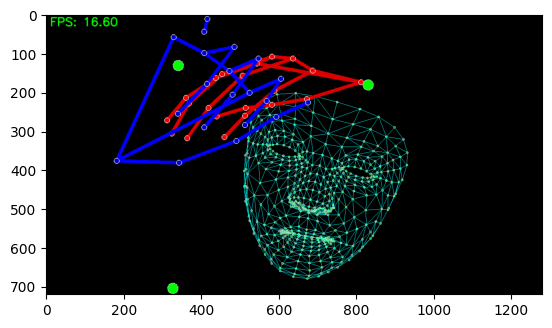

In [131]:
import matplotlib.pyplot as plt
plt.imshow(frame)

# 3. Extract 1662 Landmarks per frame

In [159]:
print("Pose landmarks: ", len(results_landmarks.pose_landmarks.landmark))
print("Face landmarks: ", len(results_landmarks.face_landmarks.landmark))
print("Right Hand landmarks: ", len(results_landmarks.right_hand_landmarks.landmark))
print("Left Hand landmarks: ", len(results_landmarks.left_hand_landmarks.landmark))

Pose landmarks:  33
Face landmarks:  468
Right Hand landmarks:  21
Left Hand landmarks:  21


In [3]:
# returns a flattened ndarray of all landmarks for a single frame, if not landmarks found then fill up with zeros
def extract_landmarks_per_frame(results_landmarks):
    pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results_landmarks.pose_landmarks.landmark]).flatten() if results_landmarks.pose_landmarks else np.zeros(33*4)
    
    face = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.face_landmarks.landmark]).flatten() if results_landmarks.face_landmarks else np.zeros(468*3)
    
    right_hand = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.right_hand_landmarks.landmark]).flatten() if results_landmarks.right_hand_landmarks else np.zeros(21*3)
    
    left_hand = np.array([[lm.x, lm.y, lm.z] for lm in results_landmarks.left_hand_landmarks.landmark]).flatten() if results_landmarks.left_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([face, pose, right_hand, left_hand])
    #return {"pose": pose, "face": face, "right_hand": right_hand, "left_hand": left_hand}


In [4]:
ext = extract_landmarks_per_frame(results_landmarks)
print(ext.shape)

NameError: name 'results_landmarks' is not defined

# 4. Setup Folders for Video Collection

### <i>Top 100 Most Common Uzbek Sign Language Words (Subject to Change)<i>

Uzbekistan's deaf community primarily uses Russian Sign Language (RSL), which has been adapted locally as Uzbek Sign Language (UzSL). It shares many signs with RSL due to historical Soviet influence, with some regional variations influenced by Uzbek culture, such as signs for local foods like "non" for bread.

The table below lists **the top 100 most common signs/concepts**, ranked by estimated frequency in everyday use (pronouns, verbs, nouns first). Each includes:

* **Uzbek Equivalent**: Corresponding Uzbek word.
* **Russian Equivalent**: Corresponding Russian word.

| #   | Uzbek       | Russian Equivalent |
|-----|-------------|--------------------|
| 1   | men         | я                  |
| 2   | siz         | ты/вы              |
| 3   | u           | он/она/оно         |
| 4   | biz         | мы                 |
| 5   | ular        | они                |
| 6   | kim         | кто                |
| 7   | nima        | что                |
| 8   | qayerda     | где                |
| 9   | qachon      | когда              |
| 10  | qanday      | как                |
| 11  | ha          | да                 |
| 12  | yo'q        | нет                |
| 13  | salom       | привет             |
| 14  | rahmat      | спасибо            |
| 15  | iltimos     | пожалуйста         |
| 16  | uzr         | извините           |
| 17  | ye          | есть               |
| 18  | ich         | пить               |
| 19  | uyqu        | спать              |
| 20  | ket         | идти               |
| 21  | kel         | приходить          |
| 22  | ko'rish     | видеть             |
| 23  | eshitish    | слышать            |
| 24  | gapirish    | говорить           |
| 25  | bilish      | знать              |
| 26  | o'ylash     | думать             |
| 27  | xohlamoq    | хотеть             |
| 28  | kerak       | нужен              |
| 29  | mumkin      | можно              |
| 30  | ish         | работать           |
| 31  | o'qimoq     | читать             |
| 32  | yozmoq      | писать             |
| 33  | o'rganmoq   | учиться            |
| 34  | o'ynamoq    | играть             |
| 35  | yugurmoq    | бежать             |
| 36  | o'tirmoq    | сидеть             |
| 37  | turmoq      | стоять             |
| 38  | uy          | дом                |
| 39  | odam        | человек            |
| 40  | ayol        | женщина            |
| 41  | bola        | ребёнок            |
| 42  | ota         | отец               |
| 43  | ona         | мать               |
| 44  | do'st       | друг               |
| 45  | oila        | семья              |
| 46  | suv         | вода               |
| 47  | ovqat       | еда                |
| 48  | kitob       | книга              |
| 49  | maktab      | школа              |
| 50  | o'qituvchi  | учитель            |
| 51  | talaba      | студент            |
| 52  | shahar      | город              |
| 53  | mashina     | машина             |
| 54  | yo'l        | дорога             |
| 55  | pul         | деньги             |
| 56  | vaqt        | время              |
| 57  | kun         | день               |
| 58  | kecha       | ночь               |
| 59  | yil         | год                |
| 60  | katta       | большой            |
| 61  | kichik      | маленький          |
| 62  | yaxshi      | хороший            |
| 63  | yomon       | плохой             |
| 64  | yangi       | новый              |
| 65  | eski        | старый             |
| 66  | issiq       | горячий            |
| 67  | sovuq       | холодный           |
| 68  | tez         | быстрый            |
| 69  | sekin       | медленный          |
| 70  | ko'p        | много              |
| 71  | oz          | мало               |
| 72  | bir         | один               |
| 73  | ikki        | два                |
| 74  | uch         | три                |
| 75  | qo'l        | рука               |
| 76  | oyoq        | нога               |
| 77  | bosh        | голова             |
| 78  | ko'z        | глаз               |
| 79  | quloq       | ухо                |
| 80  | og'iz       | рот                |
| 81  | yurak       | сердце             |
| 82  | sevgi       | любовь             |
| 83  | hayot       | жизнь              |
| 84  | osmon       | небо               |
| 85  | quyosh      | солнце             |
| 86  | oy          | луна               |
| 87  | yulduz      | звезда             |
| 88  | shamol      | ветер              |
| 89  | daraxt      | дерево             |
| 90  | gul         | цветок             |
| 91  | bozor       | рынок              |
| 92  | do'kon      | магазин            |
| 93  | dars        | урок               |
| 94  | hafta       | неделя             |
| 95  | oy          | месяц              |
| 96  | soat        | час                |
| 97  | daqiqa      | минута             |
| 98  | savol       | вопрос             |
| 99  | javob       | ответ              |
| 100 | o'yin       | игра               |

In [4]:
# Path for exported numpy arrays of extracted landmarks
DATASET_PATH = "./Data_Numpy_Arrays_RSL_UzSL"

# for the sake of example, for now simply include only 3 signs
signs = np.array(["nima", "eshitish", "salom"])

# approximate number of videos for each frame, as of now 15
num_videos = 15

# number of frames per each video, for now 60
frame_length = 60

In [5]:
# Create folder for each signed word

for sign in signs:
    for single_video in range(num_videos):
        # Each sign has its own videos/ and landmarks/ folders
        video_dir = os.path.join(DATASET_PATH, sign, "videos", f"raw-video-{single_video}")
        landmark_dir = os.path.join(DATASET_PATH, sign, "landmarks", f"video-landmark-{single_video}")
        
        try:
            os.makedirs(video_dir, exist_ok=True)
            os.makedirs(landmark_dir, exist_ok=True)
        except OSError as e:
            print(f"Error creating directories for {sign}, video {single_video}: {e}")

# Remember, each frame's Numpy Ndarray will be stored in its own .npy 
# such as frame01.npy, frame02.npy, frame03.npy

# 5. Collect Landmarks from Videos/Live-cam for Training, Validation and Testing

In [6]:
# approximate number of videos for each frame, as of now 15
num_videos = 15

# number of frames per each video, for now 60
frame_length = 60

In [18]:

VIDEO_DEVICE = 1
cap = cv2.VideoCapture(VIDEO_DEVICE)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.6, 
                                          min_tracking_confidence=0.6,
                                          static_image_mode=False)

stop_recording = False

while cap.isOpened():
    for sign in signs:
        for single_video in range(num_videos):

            # Initialize VideoWriter to record videos
            video_path = os.path.join(DATASET_PATH, sign, "videos", f"raw-video-{single_video}", f"video{single_video}.mp4")
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use mp4v codec for MP4
            video_writer = cv2.VideoWriter(video_path, fourcc, 30.0, (1280, 720)) 

            # Wait for 's' key to start countdown
            waiting_for_start = True
            while waiting_for_start:
                success, frame = cap.read()
                if not success:
                    print("Frames are not found!")
                    break
                frame_copy = frame.copy()
                frame_copy = cv2.flip(frame_copy, 1)
                cv2.putText(frame_copy, "Press 's' to start recording", 
                            (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 6, cv2.LINE_AA)
                cv2.imshow("Collecting Videos for Dataset", frame_copy)
                key = cv2.waitKey(10) & 0xFF
                if key == ord('s'):
                    waiting_for_start = False
                elif key == ord('q'):
                    stop_recording = True
                    break
            if stop_recording or not success:
                break
            
            for single_frame in range(frame_length):

                success, frame = cap.read()
                if not success:
                    print("Frames are not found!")
                    video_writer.release()
                    break

                # Save the raw frames to the video file before any processing
                video_writer.write(frame)
                
                # detect landmarks
                frame, results_landmarks = mediapipe_landmarks_detection(frame, holistic, black_bg=False)
            
                # render landmarks on video camera
                draw_landmarks_on_video(frame=frame, results_landmarks=results_landmarks)

                # flip the camera so it feels more natural
                frame = cv2.flip(frame, 1)
                
                # Applying waiting logic for collecting video
                if single_frame == 0:                  
                    # Countdown from 3 to 1 before starting collection
                    for countdown in range(5, 0, -1):
                        frame_copy = frame.copy()
                        cv2.putText(frame_copy, f"Start in {countdown} seconds!",
                                    (200, 400), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 8, cv2.LINE_AA)
                        cv2.putText(frame_copy, "Collecting Frames for Sign={}, Video Number={}".format(sign, single_video),
                                    (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 51, 51), 2, cv2.LINE_AA)
                        cv2.imshow("Collecting Videos for Dataset", frame_copy)
                        cv2.waitKey(1000)  # wait for 1 second per countdown step
                else:
                    cv2.putText(frame, "Collecting Frames for Sign={}, Video Number={}".format(sign, single_video),
                               (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 51, 51), 2, cv2.LINE_AA)
                    
                    cv2.imshow("Collecting Videos for Dataset", frame)

                # Exporting detected landmarks for each frame in .npy file
                extracted_landmarks = extract_landmarks_per_frame(results_landmarks)
                npy_path = os.path.join(DATASET_PATH, sign, "landmarks", f"video-landmark-{single_video}", f"frame-{single_frame}.npy")
                np.save(npy_path, extracted_landmarks)  # Save landmarks to .npy file

                # stops capturing frames for the current video
                if cv2.waitKey(10) & 0xFF == ord("q"):
                    stop_recording = True
                    video_writer.release()
                    break
            
            # Release video writer after all frames are written
            video_writer.release()

        # stops processing videos for the current sign
        if stop_recording:
                break
    # stops the entire capture process
    if stop_recording:
                break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

I0000 00:00:1762000939.313815 17697041 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1762000939.555557 17713906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762000939.589279 17713906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762000939.595002 17713910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762000939.597910 17713907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762000939.601444 17713904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling su

-1

# 6. Preprocess Data, Labels and Features

In [1]:
# Source - https://stackoverflow.com/a/37408638
# Posted by phev8, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-07, License - CC BY-SA 3.0
# Check the number of total frames in a video

import cv2

cap = cv2.VideoCapture("/Users/macbookair/Desktop/Video_RSL_UzSL/signer01/дом/videos/telegram-cloud-document-2-5208866938507265207.mp4")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

274
